# Working with marks in `pointpats`

In addition to the *locations* of events, a point pattern can have extra attributes
attached to each point: these are called **marks**.

Examples of marks:

- species of a tree (categorical)
- crime type (categorical)
- tree diameter (continuous)
- number of injuries at an accident (count)

In `pointpats`, a **marked point pattern** is represented by a
`PointPattern` whose underlying data frame (`pp.df`) has extra columns
beyond the coordinates, or by adding marks using the `add_marks` method.
You can also split a marked pattern into separate unmarked patterns using
`explode`. 

In this notebook we will:

1. Create an unmarked point pattern.
2. Attach categorical and numeric marks with `add_marks`.
3. Explore marks in the underlying pandas DataFrame.
4. Visualize the pattern by mark category.
5. Use `explode` to split the pattern into one pattern per mark level.
6. Compute a **weighted mean center** using a numeric mark as weights. 


## Setup and imports

We will simulate points in the unit square `[0, 1] × [0, 1]` using the
random distributions in `pointpats.random` and then work with their marks.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pointpats import PointPattern
from pointpats import random as ppr
from pointpats import weighted_mean_center, mean_center  # centrography functions

# Make results reproducible
np.random.seed(42)

# Define a simple square hull as a bounding box: [xmin, ymin, xmax, ymax]
hull = np.array([0.0, 0.0, 1.0, 1.0])
hull

array([0., 0., 1., 1.])

## 1. Create an unmarked point pattern

First, we simulate 200 locations from a homogeneous Poisson point process
in the unit square and construct a `PointPattern` from the coordinates. 


In [2]:
# Simulate 200 points in the unit square (unmarked pattern)
coords = ppr.poisson(hull, size=200)
coords.shape

(200, 2)

In [3]:
# Build an unmarked PointPattern
pp = PointPattern(coords)

pp.summary()  # quick textual summary
pp.df.head()  # underlying DataFrame with coordinates only (x, y)

Point Pattern
200 points
Bounding rectangle [(0.000171181152699873,0.010338154916560871), (0.9942427152327866,0.9892658503605231)]
Area of window: 0.9731241559634635
Intensity estimate for window: 205.52362077784977
          x         y
0  0.552586  0.448690
1  0.493656  0.826143
2  0.023953  0.837835
3  0.889946  0.989266
4  0.250946  0.805441


,x,y
0,0.552586,0.448690
1,0.493656,0.826143
2,0.023953,0.837835
3,0.889946,0.989266
4,0.250946,0.805441


At this stage, `pp` has only coordinates (`x`, `y`) and **no marks**.

Internally, `PointPattern` stores the data in a pandas DataFrame (`pp.df`).
Any extra columns we add will be treated as marks (attributes) of the
points. 


## 2. Add categorical and numeric marks with `add_marks`

We will assign two marks to each point:

- `type`: a **categorical** mark taking values `'A'` or `'B'`.
- `value`: a **continuous** mark drawn from a normal distribution.

We use the `add_marks(marks, mark_names=None)` method of `PointPattern`
to attach these attributes. 


In [4]:
n = pp.n

# Categorical mark: two types, A and B
types = np.random.choice(["A", "B"], size=n, p=[0.6, 0.4])

# Numeric mark: e.g. "intensity" or "size" for each event
values = np.random.gamma(shape=2.0, scale=1.0, size=n)

# Attach both marks to the point pattern
pp.add_marks([types, values], mark_names=["type", "value"])

pp.df.head()

,x,y,type,value
0,0.552586,0.448690,A,0.933881
1,0.493656,0.826143,B,1.984845
2,0.023953,0.837835,B,2.074374
3,0.889946,0.989266,A,0.904084
4,0.250946,0.805441,A,5.422076


Now `pp` is a **marked point pattern**. The DataFrame has four columns:
`x`, `y` (coordinates) and `type`, `value` (marks).

We can work with marks using standard pandas tools, for example to
compute simple summaries by type:

In [5]:
# Counts by categorical mark
pp.df["type"].value_counts()

type
A    122
B     78
Name: count, dtype: int64

In [6]:
# Mean of the numeric mark by type
pp.df.groupby("type")["value"].mean()

type
A    2.080500
B    2.019942
Name: value, dtype: float64

## 3. Visualizing a marked point pattern

Let’s write a helper to plot points colored by a categorical mark, here
`type`.


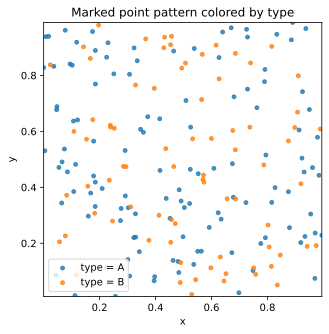

In [7]:
def plot_marked_pattern(pp, mark_column="type", ax=None, title=None):
    """Plot a marked point pattern, coloring by a categorical mark.

    Parameters
    ----------
    pp : pointpats.PointPattern
        Marked point pattern.
    mark_column : str
        Column in `pp.df` containing categorical marks.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on.
    title : str, optional
        Plot title.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    df = pp.df
    categories = df[mark_column].astype("category")
    cats = categories.cat.categories

    # Basic color cycle
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for i, cat in enumerate(cats):
        sub = df[categories == cat]
        ax.scatter(sub[pp.coord_names[0]], sub[pp.coord_names[1]],
                   s=15, label=f"{mark_column} = {cat}",
                   color=colors[i % len(colors)], alpha=0.8)

    # Use the window of the pattern to set plot limits
    xmin, ymin, xmax, ymax = pp.window.bbox
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel(pp.coord_names[0])
    ax.set_ylabel(pp.coord_names[1])
    if title:
        ax.set_title(title)
    ax.legend(loc="best")

    return ax


plot_marked_pattern(pp, mark_column="type",
                    title="Marked point pattern colored by type")
plt.show()

The colors distinguish the mark categories (`type = 'A'` vs `type = 'B'`).
You can adapt the plotting function to map numeric marks to size or
color gradients if desired.

## 4. Splitting a marked pattern with `explode`

To analyze each mark category as its own point pattern, we can use the
`explode(mark)` method of `PointPattern`. It returns a list of
`PointPattern` objects, one per unique value of the mark. 


In [8]:
# Unique categories in the "type" mark
categories = pp.df["type"].astype("category").cat.categories
categories

Index(['A', 'B'], dtype='object')

In [9]:
# Explode into a list of unmarked patterns, one per category
pps_by_type = pp.explode("type")

len(pps_by_type)  # should match the number of unique categories

2

In [10]:
for cat, sub_pp in zip(categories, pps_by_type):
    print(f"Category {cat!r} -> {sub_pp.n} points")

Category 'A' -> 122 points
Category 'B' -> 78 points


We can visualize each category in its own panel to compare their
spatial distributions.

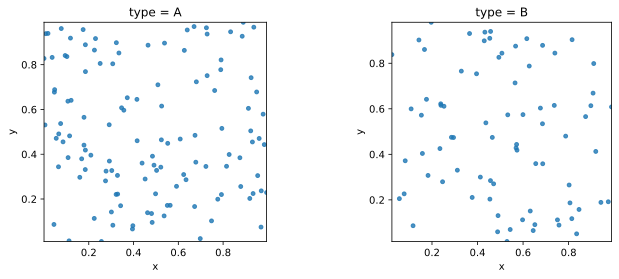

In [11]:
fig, axes = plt.subplots(1, len(pps_by_type), figsize=(5 * len(pps_by_type), 4))
if len(pps_by_type) == 1:
    axes = [axes]

for ax, cat, sub_pp in zip(axes, categories, pps_by_type):
    df = sub_pp.df
    xname, yname = sub_pp.coord_names

    ax.scatter(df[xname], df[yname], s=15, alpha=0.8)
    xmin, ymin, xmax, ymax = sub_pp.window.bbox
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"type = {cat}")
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)

plt.tight_layout()
plt.show()


Each panel now shows the points belonging to a single mark category.

This is useful when you want to treat each type as its **own** point
pattern (e.g., trees of different species, crimes of different types)
and compare their intensities, clustering, or nearest-neighbor behavior.

## 5. Using numeric marks as weights: weighted mean center

Numeric marks are often used as **weights** when summarizing the pattern.
For example, you might weight accidents by the number of injuries or
trees by their biomass.

The function `weighted_mean_center(points, weights)` computes a
weighted mean center, where each point contributes proportionally to its
weight. 

Here we compare the (unweighted) mean center of the pattern to the
weighted mean center using the `value` mark as weights.

In [12]:
# Unweighted mean center
mc = mean_center(pp.points)

# Weighted mean center using the numeric mark "value" as weights
wmc = weighted_mean_center(pp.points, pp.df["value"].values)

mc, wmc

(array([0.4874871, 0.4928248]), array([0.50010306, 0.50329395]))

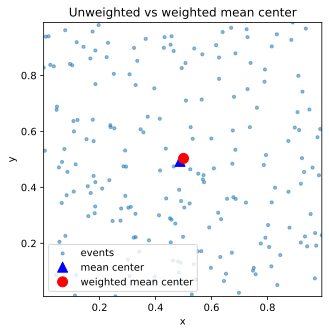

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot marked pattern with small gray points
ax.scatter(pp.df[pp.coord_names[0]], pp.df[pp.coord_names[1]],
           s=10, alpha=0.5, label="events")

xmin, ymin, xmax, ymax = pp.window.bbox
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("equal", adjustable="box")

# Add unweighted and weighted mean centers
ax.plot(mc[0], mc[1], "b^", markersize=10, label="mean center")
ax.plot(wmc[0], wmc[1], "ro", markersize=10, label="weighted mean center")

ax.set_xlabel(pp.coord_names[0])
ax.set_ylabel(pp.coord_names[1])
ax.set_title("Unweighted vs weighted mean center")
ax.legend()

plt.show()

The weighted mean center is pulled toward points with larger `value`.
This is a simple example of how numeric marks can affect spatial
summaries.


## 6. Creating a marked pattern directly from an array

Instead of starting with an unmarked pattern and calling `add_marks`,
you can also pass a full `(n, p)` array (coordinates + attributes) into
`PointPattern` and specify `names` for the columns. 

In this example we build a second point pattern whose coordinates and
marks are all stored in a single NumPy array:

In [14]:
# Build a new (n, 4) array: x, y, type_code, value
type_code = (types == "B").astype(float)  # 0 for A, 1 for B
points_with_marks = np.column_stack([pp.points, type_code, values])

names = ["x", "y", "type_code", "value"]
pp2 = PointPattern(points_with_marks, names=names)

pp2.df.head()

,x,y,type_code,value
0,0.552586,0.448690,0.0,0.933881
1,0.493656,0.826143,1.0,1.984845
2,0.023953,0.837835,1.0,2.074374
3,0.889946,0.989266,0.0,0.904084
4,0.250946,0.805441,0.0,5.422076


Here, `pp2` is also a marked point pattern: `x`, `y` are coordinates,
and `type_code`, `value` are marks.

This pattern (constructing a full `(n, p)` table and passing it to
`PointPattern`) is convenient when your data already live in a
DataFrame or when loading from a CSV or GIS table.

## Recap

In this notebook, we have:

- Built an **unmarked** `PointPattern` from simulated coordinates.
- Attached **categorical** and **numeric** marks with `add_marks`.
- Used `pp.df` (a pandas DataFrame) to summarize marks by category.
- Visualized a marked point pattern with color by categorical mark.
- Applied `explode` to split a marked pattern into separate patterns,
  one per mark category.
- Computed a **weighted mean center** using a numeric mark as weights.
- Created a marked pattern directly from a full `(n, p)` array with
  coordinate and mark columns.

These tools form the core of working with **marked point patterns** in
`pointpats`. You can combine them with quadrat statistics, distance-based
functions, and space–time tests for more advanced analyses.
